![header](../figures/logos_partenaires._cmems_se.jpg)


<div class="alert alert-block alert-success">
<h1><center>Compare SSH, gradients and Laplacian pdf in Gulf Stream</center></h1></div>

***
**Authors:**  Datlas, IGE, IMEDEA & CLS <br>
**Copyright:** 2022 Datlas, IGE, IMEDEA & CLS <br>
**License:** MIT

In [1]:
import os
import glob
import sys
sys.path.append('..')
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import scipy.signal as sig


from src import mod_plot
from src import mod_switchvar
from src import mod_spectral
from src.dict_regions_info import *

In [2]:

region_info = RegionInfo('GS_info').region_info   # Region dictionary info from dict_regions_info.py

denoising_name1 = 'Gomez_v2'
denoising_name2 = 'UnetGomez'

len_seg = 500 # in num_lines point (i.e. every 2km)

<div class="alert alert-info" role="alert">

<h2>A - 1 day orbit </h2>

</div>
 

In [3]:
path_data = '../denoised_data/swot_1j_share_GS_gomezfilt2_Unetgomezfilt.nc'

orbit = '1d'

ds_SWOT = xr.open_mfdataset(path_data)
  

In [4]:
ds_SWOT

<xarray.Dataset>
Dimensions:             (num_lines: 12222, num_pixels: 69)
Coordinates:
    latitude            (num_lines, num_pixels) float32 dask.array<chunksize=(12222, 69), meta=np.ndarray>
    longitude           (num_lines, num_pixels) float32 dask.array<chunksize=(12222, 69), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time                (num_lines, num_pixels) datetime64[ns] dask.array<chunksize=(12222, 69), meta=np.ndarray>
    mss                 (num_lines, num_pixels) float32 dask.array<chunksize=(12222, 69), meta=np.ndarray>
    swh_model           (num_lines, num_pixels) float32 dask.array<chunksize=(12222, 69), meta=np.ndarray>
    ssha_new_editing    (num_lines, num_pixels) float32 dask.array<chunksize=(12222, 69), meta=np.ndarray>
    new_quality_flag    (num_lines, num_pixels) float64 dask.array<chunksize=(12222, 69), meta=np.ndarray>
    ssha_denoised_unet  (num_lines, num_pixels) float32 dask.array<chunksize=(12222, 69), meta=np.ndarray>
    ssha_gomezfilt      (num_lines, num_pixels) float32 dask.array<chunksize=(12222, 69), meta=np.ndarray>
    ssha_unetgomezfilt  (num_lines, num_pixels) float32 dask.array<chunksize=(12222, 69), meta=np.ndarray>
Attributes: (12/41)
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    creator_name:                    DUACS - Data Unification and Altimeter C...
    creator_url:                     https://aviso.altimetry.fr
    institution:                     CNES
    license:                         https://www.aviso.altimetry.fr/fileadmin...
    ...                              ...
    time_coverage_begin:             2023-04-23T17:58:31Z
    time_coverage_end:               2023-04-23T18:49:36Z
    geospatial_lat_min:              -78.272196
    geospatial_lat_max:              78.272247
    geospatial_lon_min:              8.4e-05
    geospatial_lon_max:              359.999504

## Compute psd for SSH

In [15]:
%%time  

name_var = 'ssh_new_editing'
ds_SWOT = ds_SWOT.assign(ssh_new_editing=ds_SWOT["ssha_new_editing"])
ssh_new_editing_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'ssh_denoised_unet'
ds_SWOT = ds_SWOT.assign(ssh_denoised_unet=ds_SWOT["ssha_denoised_unet"])
ssh_denoised_unet_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'ssh_gomezfilt'
ds_SWOT = ds_SWOT.assign(ssh_gomezfilt=ds_SWOT["ssha_gomezfilt"])
ssh_denoised1_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'ssh_unetgomezfilt'
ds_SWOT = ds_SWOT.assign(ssh_unetgomezfilt=ds_SWOT["ssha_unetgomezfilt"])
ssh_denoised2_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

wavenum, psd_new_editing = sig.welch(np.ravel(ssh_new_editing_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_unet = sig.welch(np.ravel(ssh_denoised_unet_segs),0.5,nperseg=len_seg,noverlap=0)
wavenum, psd_denoised1 = sig.welch(np.ravel(ssh_denoised1_segs),0.5,nperseg=len_seg,noverlap=0)
wavenum, psd_denoised2 = sig.welch(np.ravel(ssh_denoised2_segs),0.5,nperseg=len_seg,noverlap=0)

wavenum, psd_new_editing, psd_denoised_unet, psd_denoised1, psd_denoised2 = wavenum[:-1], psd_new_editing[:-1], psd_denoised_unet[:-1], psd_denoised1[:-1], psd_denoised2[:-1] 


Number of segs 466 of size 500
Number of segs 466 of size 500
Number of segs 466 of size 500
Number of segs 466 of size 500
CPU times: user 33.5 s, sys: 410 ms, total: 33.9 s
Wall time: 36.7 s


## Plot psd for SSH

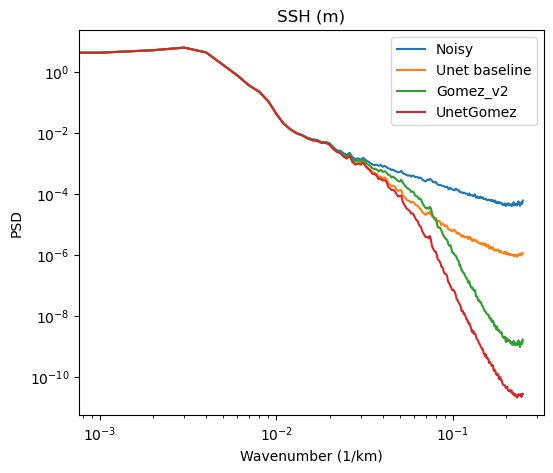

In [17]:
plt.figure(figsize=(6,5))
plt.title('SSH (m)')
plt.loglog(wavenum,psd_new_editing,label='Noisy')
plt.loglog(wavenum,psd_denoised_unet,label='Unet baseline')
plt.loglog(wavenum,psd_denoised1,label=denoising_name1)
plt.loglog(wavenum,psd_denoised2,label=denoising_name2)
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('../figures/psd_compare_'+region_info['name']+'_'+orbit+'_ssh.png')

plt.show()



## Compute SSH gradients and Laplacian

In [9]:
grad_new_editing, lapl_new_editing = mod_switchvar.deriv1and2(ds_SWOT.ssha_new_editing)
grad_denoised_unet, lapl_denoised_unet = mod_switchvar.deriv1and2(ds_SWOT.ssha_denoised_unet)
grad_denoised1, lapl_denoised1 = mod_switchvar.deriv1and2(ds_SWOT.ssha_gomezfilt)
grad_denoised2, lapl_denoised2 = mod_switchvar.deriv1and2(ds_SWOT.ssha_unetgomezfilt)


ds_SWOT = ds_SWOT.assign(grad_new_editing=lambda ds_SWOT: ds_SWOT.ssha_new_editing * 0 + grad_new_editing)
ds_SWOT = ds_SWOT.assign(grad_denoised_unet=lambda ds_SWOT: ds_SWOT.ssha_denoised_unet * 0 + grad_denoised_unet)
ds_SWOT = ds_SWOT.assign(grad_denoised1=lambda ds_SWOT: ds_SWOT.ssha_gomezfilt * 0 + grad_denoised1)
ds_SWOT = ds_SWOT.assign(grad_denoised2=lambda ds_SWOT: ds_SWOT.ssha_unetgomezfilt * 0 + grad_denoised2)

ds_SWOT = ds_SWOT.assign(lapl_new_editing=lambda ds_SWOT: ds_SWOT.ssha_new_editing * 0 + lapl_new_editing)
ds_SWOT = ds_SWOT.assign(lapl_denoised_unet=lambda ds_SWOT: ds_SWOT.ssha_denoised_unet * 0 + lapl_denoised_unet)
ds_SWOT = ds_SWOT.assign(lapl_denoised1=lambda ds_SWOT: ds_SWOT.ssha_gomezfilt * 0 + lapl_denoised1)
ds_SWOT = ds_SWOT.assign(lapl_denoised2=lambda ds_SWOT: ds_SWOT.ssha_unetgomezfilt * 0 + lapl_denoised2)


## Compute psd for gradients

In [10]:
%%time  

name_var = 'grad_new_editing'
ssh_new_editing_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'grad_denoised_unet'
ssh_denoised_unet_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'grad_denoised1'
ssh_denoised1_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'grad_denoised2'
ssh_denoised2_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

wavenum, psd_new_editing = sig.welch(np.ravel(ssh_new_editing_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_unet = sig.welch(np.ravel(ssh_denoised_unet_segs),0.5,nperseg=len_seg,noverlap=0)
wavenum, psd_denoised1 = sig.welch(np.ravel(ssh_denoised1_segs),0.5,nperseg=len_seg,noverlap=0)
wavenum, psd_denoised2 = sig.welch(np.ravel(ssh_denoised2_segs),0.5,nperseg=len_seg,noverlap=0)

wavenum, psd_new_editing, psd_denoised_unet, psd_denoised1, psd_denoised2 = wavenum[:-1], psd_new_editing[:-1], psd_denoised_unet[:-1], psd_denoised1[:-1], psd_denoised2[:-1] 


Number of segs 466 of size 500
Number of segs 466 of size 500
Number of segs 466 of size 500
Number of segs 466 of size 500
CPU times: user 38.9 s, sys: 477 ms, total: 39.4 s
Wall time: 44.5 s


## Plot psd for gradients

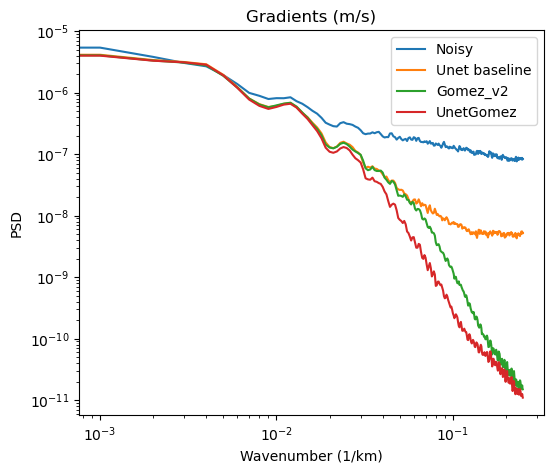

In [11]:
plt.figure(figsize=(6,5))
plt.title('Gradients (m/s)')
plt.loglog(wavenum,psd_new_editing,label='Noisy')
plt.loglog(wavenum,psd_denoised_unet,label='Unet baseline')
plt.loglog(wavenum,psd_denoised1,label=denoising_name1)
plt.loglog(wavenum,psd_denoised2,label=denoising_name2)
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('../figures/psd_compare_'+region_info['name']+'_'+orbit+'_grad.png')

plt.show()



## Compute psd for Laplacians

In [12]:
%%time  

name_var = 'lapl_new_editing'
ssh_new_editing_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'lapl_denoised_unet'
ssh_denoised_unet_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'lapl_denoised1'
ssh_denoised1_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'lapl_denoised2'
ssh_denoised2_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

wavenum, psd_new_editing = sig.welch(np.ravel(ssh_new_editing_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_unet = sig.welch(np.ravel(ssh_denoised_unet_segs),0.5,nperseg=len_seg,noverlap=0)
wavenum, psd_denoised1 = sig.welch(np.ravel(ssh_denoised1_segs),0.5,nperseg=len_seg,noverlap=0)
wavenum, psd_denoised2 = sig.welch(np.ravel(ssh_denoised2_segs),0.5,nperseg=len_seg,noverlap=0)



wavenum, psd_new_editing, psd_denoised_unet, psd_denoised1, psd_denoised2 = wavenum[:-1], psd_new_editing[:-1], psd_denoised_unet[:-1], psd_denoised1[:-1], psd_denoised2[:-1] 


Number of segs 342 of size 500
Number of segs 342 of size 500
Number of segs 342 of size 500
Number of segs 342 of size 500
CPU times: user 33.5 s, sys: 441 ms, total: 33.9 s
Wall time: 37.4 s


## Plot psd for Laplacians

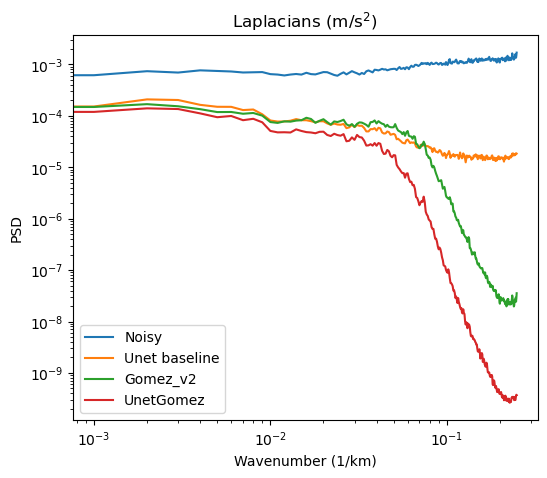

In [13]:
plt.figure(figsize=(6,5))
plt.title('Laplacians (m/s$^2$)')
plt.loglog(wavenum,psd_new_editing,label='Noisy')
plt.loglog(wavenum,psd_denoised_unet,label='Unet baseline')
plt.loglog(wavenum,psd_denoised1,label=denoising_name1)
plt.loglog(wavenum,psd_denoised2,label=denoising_name2)
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('../figures/psd_compare_'+region_info['name']+'_'+orbit+'_lapl.png')

plt.show()

